In [2]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.efficientnet import preprocess_input as ef_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pickle

In [5]:
# Define constants
DATASET_PATH = r"D:\Projects\Stroke_Classification\dataset"
BALANCED_PATH = r"D:\Projects\Stroke_Classification\balanced"
PREPROCESSED_PATH = r"D:\Projects\Stroke_Classification\preprocessed_data"
SPLIT_PATH = r"D:\Projects\Stroke_Classification\Split_data"
FEATURES_PATH = r"D:\Projects\Stroke_Classification\feature_data"
CLASSES = ["Normal", "Haemorrhagic", "Ischemic"]

In [7]:
# Step 1: Verify dataset structure
def check_dataset_structure(root_path):
    class_sizes = {}
    for category in CLASSES:
        category_path = os.path.join(root_path, category)
        if os.path.exists(category_path):
            num_files = len(os.listdir(category_path))
            class_sizes[category] = num_files
    return class_sizes

In [8]:
counts = check_dataset_structure(DATASET_PATH)

In [9]:
counts

{'Normal': 399, 'Haemorrhagic': 186, 'Ischemic': 30}

In [10]:
# Step 2: Plot class distribution
def visualize_class_distribution(data_counts):
    print(data_counts)
    plt.figure(figsize=(7, 5))
    sns.barplot(x=list(data_counts.keys()), y=list(data_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Stroke Classes")
    plt.ylabel("Number of Images")
    plt.show()


{'Normal': 399, 'Haemorrhagic': 186, 'Ischemic': 30}


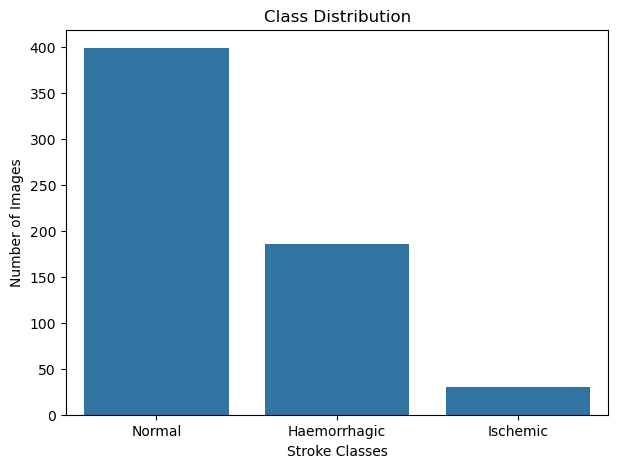

In [11]:
visualize_class_distribution(counts)

In [12]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

def visualize_dataset(dataset_path, classes, num_images=3):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(12, 12))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)

        # Select random images
        selected_images = random.sample(images, num_images)

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap="gray")  # Use "gray" for grayscale images
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{class_name}\n{img_name}", fontsize=10)

    plt.tight_layout()
    plt.show()
    

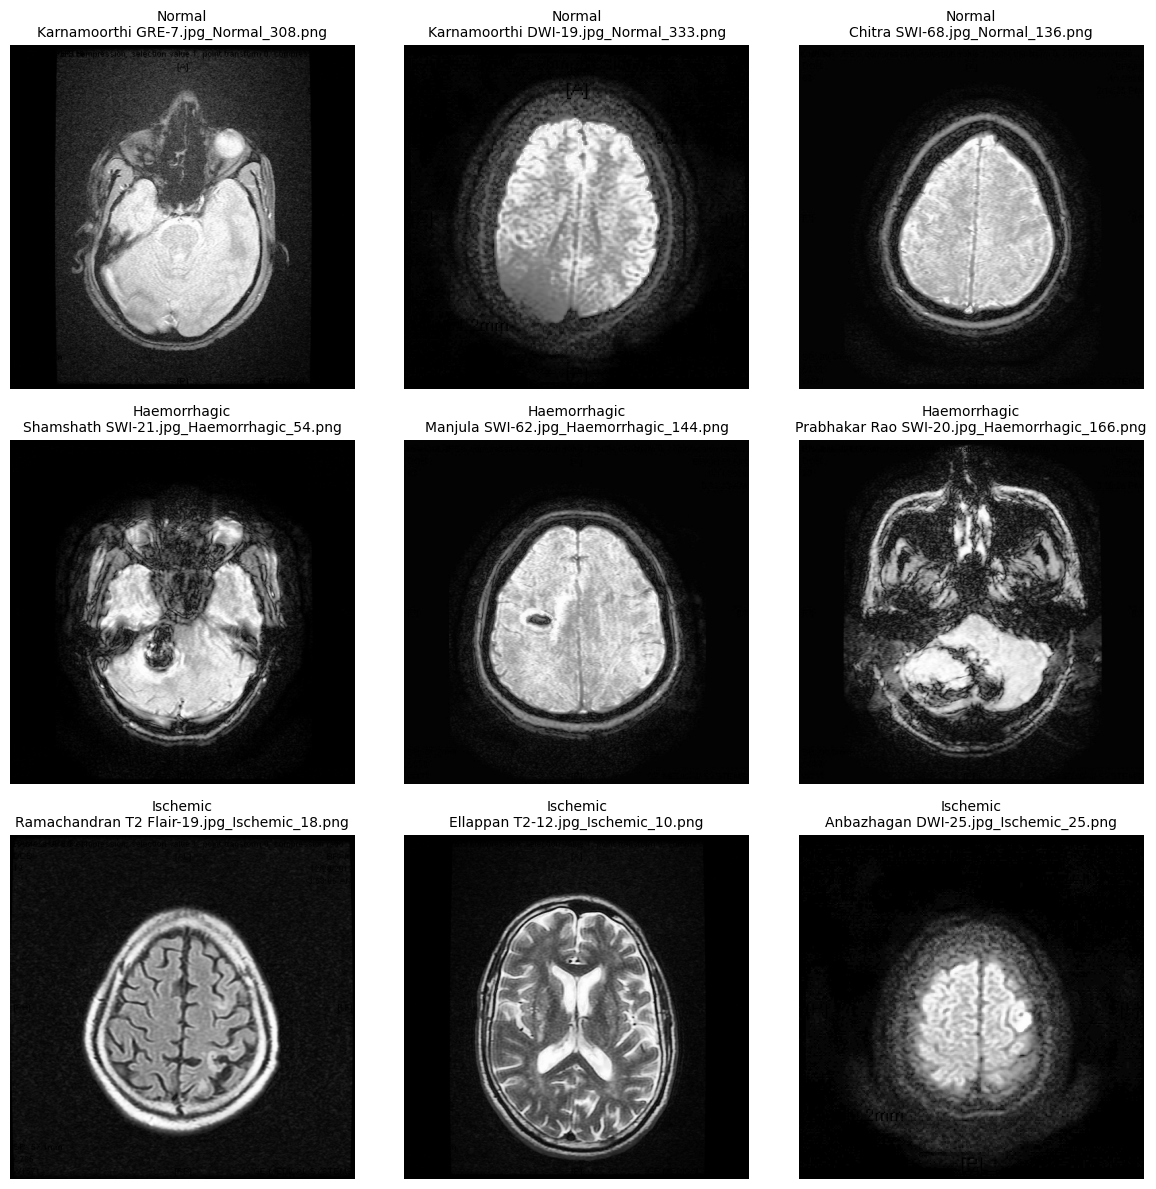

In [13]:
visualize_dataset(DATASET_PATH, CLASSES)

In [14]:
def balance_dataset(src_root, dst_root):
    min_class_size = min(counts.values())  # Get the smallest class size

    print(f"Smallest class size: {min_class_size}")

    # Step 2: Downsample each class to match `min_class_size`
    for category in CLASSES:
        os.makedirs(os.path.join(dst_root, category), exist_ok=True)
        src_path = os.path.join(src_root, category)
        dst_path = os.path.join(dst_root, category)

        # Get list of images in the source category folder
        image_list = [f for f in os.listdir(src_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Select `min_class_size` images randomly
        selected_images = random.sample(image_list, min_class_size)

        # Copy selected images to the destination folder
        for img in selected_images:
            shutil.copy(os.path.join(src_path, img), os.path.join(dst_path, img))

        # Print the size of the balanced dataset for this class
        print(f"Class '{category}': {len(selected_images)} images copied to {dst_path}")

In [15]:
balance_dataset(DATASET_PATH, BALANCED_PATH)

Smallest class size: 30
Class 'Normal': 30 images copied to D:\Projects\Stroke_Classification\balanced\Normal
Class 'Haemorrhagic': 30 images copied to D:\Projects\Stroke_Classification\balanced\Haemorrhagic
Class 'Ischemic': 30 images copied to D:\Projects\Stroke_Classification\balanced\Ischemic


{'Normal': 30, 'Haemorrhagic': 30, 'Ischemic': 30}


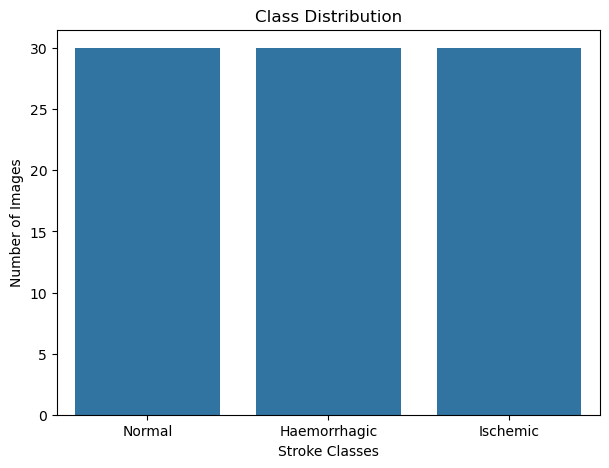

In [16]:
counts = check_dataset_structure(BALANCED_PATH)
visualize_class_distribution(counts)


In [17]:
# Step 5: Preprocess images (CLAHE and Skull Stripping)
def preprocess_images(src_root, dst_root):
    os.makedirs(dst_root, exist_ok=True)
    for category in CLASSES:
        src_dir = os.path.join(src_root, category)
        dst_dir = os.path.join(dst_root, category)
        os.makedirs(dst_dir, exist_ok=True)
        for img_file in tqdm(os.listdir(src_dir), desc=f"Preprocessing {category}"):
            img_path = os.path.join(src_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_resized = cv2.resize(img, (224, 224))
            gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray_img)
            blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
            _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)
            mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
            stripped = cv2.bitwise_and(enhanced, enhanced, mask=mask)
            final_img = cv2.cvtColor(stripped, cv2.COLOR_GRAY2BGR)
            cv2.imwrite(os.path.join(dst_dir, img_file), final_img)
    print(f"✅ Preprocessing Done! Saved to {dst_root}")

In [18]:
preprocess_images(BALANCED_PATH, PREPROCESSED_PATH)

Preprocessing Ischemic: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.04it/s]

✅ Preprocessing Done! Saved to D:\Projects\Stroke_Classification\preprocessed_data


In [19]:
# Step 6: Split dataset into Train/Validation/Test
def split_data(src_root, dst_root):
    splits = {"Train": 0.7, "Validation": 0.15, "Test": 0.15}
    for split in splits:
        for category in CLASSES:
            os.makedirs(os.path.join(dst_root, split, category), exist_ok=True)
    for category in CLASSES:
        src_dir = os.path.join(src_root, category)
        images = os.listdir(src_dir)
        random.shuffle(images)
        train_end = int(len(images) * splits["Train"])
        val_end = train_end + int(len(images) * splits["Validation"])
        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]
        for img in tqdm(train_imgs, desc=f"{category} -> Train"):
            shutil.copy(os.path.join(src_dir, img), os.path.join(dst_root, "Train", category, img))
        for img in tqdm(val_imgs, desc=f"{category} -> Validation"):
            shutil.copy(os.path.join(src_dir, img), os.path.join(dst_root, "Validation", category, img))
        for img in tqdm(test_imgs, desc=f"{category} -> Test"):
            shutil.copy(os.path.join(src_dir, img), os.path.join(dst_root, "Test", category, img))

In [20]:
split_data(PREPROCESSED_PATH, SPLIT_PATH)

Ischemic -> Test: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 118.68it/s]


In [21]:
# TensorFlow and Keras Models
from tensorflow.keras.applications import ResNet50, ResNet101, DenseNet121, DenseNet169
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB7
from tensorflow.keras.applications import InceptionV3, VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten

In [22]:
# Step 7: Extract features using EfficientNetB0
def extract_and_save_features(src_root, dst_root):
    os.makedirs(dst_root, exist_ok=True)
    model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
    for split in ["Train", "Validation", "Test"]:
        features, labels = [], []
        split_dir = os.path.join(src_root, split)
        for category in CLASSES:
            category_dir = os.path.join(split_dir, category)
            for img_file in tqdm(os.listdir(category_dir), desc=f"{split} - {category}"):
                img_path = os.path.join(category_dir, img_file)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = ef_preprocess(img)
                img = np.expand_dims(img, axis=0)
                feature = model.predict(img, verbose=0)[0]
                features.append(feature)
                labels.append(CLASSES.index(category))
        features, labels = np.array(features), np.array(labels)
        with open(os.path.join(dst_root, f"{split}_features.pkl"), "wb") as f:
            pickle.dump((features, labels), f)
        print(f"✅ {split} Features Saved! Shape: {features.shape}")

In [23]:
extract_and_save_features(SPLIT_PATH, FEATURES_PATH)

Train - Ischemic: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.82it/s]


✅ Train Features Saved! Shape: (63, 1280)


Validation - Ischemic: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.78it/s]


✅ Validation Features Saved! Shape: (12, 1280)


Test - Ischemic: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]

✅ Test Features Saved! Shape: (15, 1280)
